# Text Classification and Analysis using Deep Learning

##### By: Shreya Valaboju
##### Section: CS 4395.001
##### * Before executing this notebook, ensure all necessary libraries/modules are installed. Simply run the notebook from top to bottom. 

The dataset is used to solve a multi-class classification problem, classifying emails as fraud, commerical spam, phishing, or none (false-positive). This dataset is dervied from Kaggle, and is called "Phishing Email Data by Type." In this notebook, we will try to train our model using various algorithms, such as a simple sequential model, Recurrent Neural Network (RNN), and a Convolutional Neural Network (CNN), to be able to predict whether a given email message is fraud, commerical spam, phishing, or none (false-positive). The dataset has 3 columns: 'Subject', 'Text', and 'Type.'The 'Text' column holds the entire email message. The subject of the emails is also another attribute in the dataset, however, in this notebook we will only be using the "Text" and "Type" columns. We will vectorize the "Text" column to derive the features for the model and the "Type" will represent our target class. This project builds on the previous 'Text Classification using Naive Bayes, Logistic Regression, and Neural Network' notebook and uses the same dataset. Here is the link to the dataset: 
https://www.kaggle.com/datasets/charlottehall/phishing-email-data-by-type



#### 1. Import Libraries and Preprocessing

In [59]:
# import libraries
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
# get a text classification dataset (hosted on a public url via github)
data_url = "https://raw.githubusercontent.com/shreyavala/nlp_text_classification_data/main/phishing_data_by_type.csv"
df=pd.read_csv(data_url)
df

,Subject,Text,Type
0,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\...,Fraud
1,URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",Fraud
2,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,Fraud
3,from Mrs.Johnson,Goodday Dear\n\n\nI know this mail will come t...,Fraud
4,Co-Operation,FROM MR. GODWIN AKWESI\nTEL: +233 208216645\nF...,Fraud
...,...,...,...
154,These Bags Just Arrived For Spring,Bags so perfect—you'll never want to be withou...,Commercial Spam
155,POTUS Comes to Broadway this April! Get Ticket...,INAUGURAL BROADWAY PERFORMANCE APRIL 14\r\nA N...,Commercial Spam
156,Let’s talk about Bridgerton!,GET THE BEST OF EVERYTHING IN THE APP\n\nSTARB...,Commercial Spam
157,MONDAY MIX: All eyes on Ukraine,Hi!\n \nSpring forward with our newest noPac c...,Commercial Spam


In [61]:
print("Shape(Rows, Columns): ",df.shape)

Shape(Rows, Columns):  (159, 3)


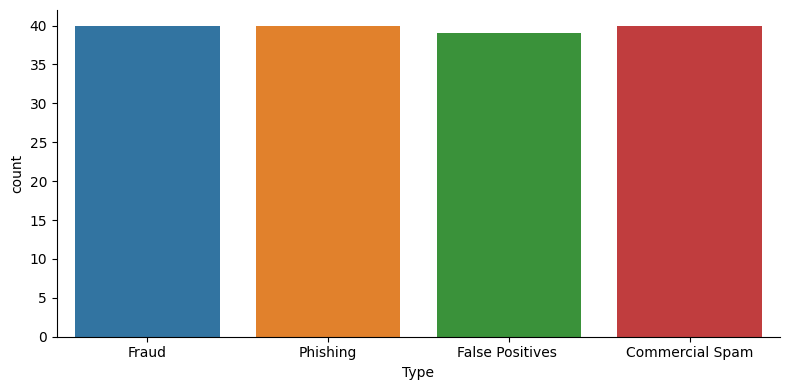

In [62]:
# creates a graph showing the distribution of the target classes

sns.catplot(data=df, kind='count', x='Type', height=4, aspect=2)

From this distribution we can see that the classes are fairly balanced. There is a proportional number of instances between Fraud, Phishing, False Positives, and Commerical Spam emails. We do not need to undersample or oversample any class in this dataset. This dataset it relatively small, with 159 instances and 3 attributes. 


In [63]:
# preprocess the 'Text' column (lowercase, remove punctuation and numbers)
df['Text'] = df['Text'].str.lower() # lower
df['Text'] = df['Text'].str.replace('[^\w\s]','') # remove punctuation
df['Text'] = df['Text'].str.replace('\n','') # remove newlines
df['Text'] = df['Text'].str.replace('\t','') # remove tabs
df['Text'] = df['Text'].str.replace('\d+', '') # remove numbers
df

<ipython-input-63-a91182193439>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('[^\w\s]','') # remove punctuation
<ipython-input-63-a91182193439>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('\d+', '') # remove numbers


,Subject,Text,Type
0,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,urgent business assistance and partnershipdear...,Fraud
1,URGENT ASSISTANCE /RELATIONSHIP (P),dear friendi am mr ben suleman a custom office...,Fraud
2,GOOD DAY TO YOU,from his royal majesty hrm crown ruler of elem...,Fraud
3,from Mrs.Johnson,goodday deari know this mail will come to you ...,Fraud
4,Co-Operation,from mr godwin akwesitel fax before i introd...,Fraud
...,...,...,...
154,These Bags Just Arrived For Spring,bags so perfectyoull never want to be without ...,Commercial Spam
155,POTUS Comes to Broadway this April! Get Ticket...,inaugural broadway performance april \ra new c...,Commercial Spam
156,Let’s talk about Bridgerton!,get the best of everything in the appstarbucks...,Commercial Spam
157,MONDAY MIX: All eyes on Ukraine,hi spring forward with our newest nopac course...,Commercial Spam


In [64]:
# use tf-idf vectorization to extract features (tf-idf frequencies) and preprocess by lemmatization
class LemmaTokenizer:
     def __init__(self):
         self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vectorizer = TfidfVectorizer(stop_words = 'english',tokenizer=LemmaTokenizer(),min_df=3) # intitialize a tf-idf vectorizer (with stopwords removal and lemmatization)

vectorized_data = vectorizer.fit_transform(df['Text'].values.astype('U')) # tell the vectorizer to read our data

# construct a dataframe with vectorized words (dataframe will be large)
df_vectorized= pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
df_vectorized.head()

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


,abacha,abandoned,abidjan,able,abroad,academic,accept,accepted,access,accordance,...,youas,youi,youll,young,youre,youth,youtube,youve,zip,𝘧𝘳𝘰𝘮
0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.14028,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.070671,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.200996,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.000000,0.0,0.068949,0.0,0.0,0.0,...,0.083368,0.065382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2. Train/Test Split w/ Encoding

In [65]:
# train/test split with encoding
from sklearn.preprocessing import LabelEncoder

X = df_vectorized  # drop any other columns/features deemed unecessary for the X
y = df["Type"] # target class

# add an encoder for the target class, categorical -> numerical 
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(y_encoded)

# split train/test 
x_train, x_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded,test_size = 0.25,random_state = 42) # split data into 75% train, 25% test

print("X shape: ", x_train.shape, x_test.shape)
print("y shape: ", y_train_encoded.shape, y_test_encoded.shape)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
X shape:  (119, 1251) (40, 1251)
y shape:  (119,) (40,)


#### 3. Run and Evaluate Sequential, RNN, CNN

In [66]:
# import libraries for deep learning models
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, Embedding, LSTM, Dense
from keras import regularizers

###### A. Sequential Model

In [67]:
# build and fit the model
vocab_size = len(vectorizer.vocabulary_)

model = models.Sequential()
model.add(layers.Dense(32, input_dim=vocab_size, kernel_initializer='normal', activation='relu'))
model.add(layers.Dense(4, activation='softmax',kernel_initializer='normal')) # use softmax bc we have 4 target classes

In [68]:
# compile
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [69]:
model.fit(x_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
4/4 [==============================] - 1s 74ms/step - loss: 1.3857 - accuracy: 0.2710 - val_loss: 1.3851 - val_accuracy: 0.2500
Epoch 2/50
4/4 [==============================] - 0s 13ms/step - loss: 1.3772 - accuracy: 0.5140 - val_loss: 1.3833 - val_accuracy: 0.4167
Epoch 3/50
4/4 [==============================] - 0s 15ms/step - loss: 1.3695 - accuracy: 0.6449 - val_loss: 1.3811 - val_accuracy: 0.4167
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 1.3604 - accuracy: 0.7664 - val_loss: 1.3783 - val_accuracy: 0.4167
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 1.3497 - accuracy: 0.8224 - val_loss: 1.3743 - val_accuracy: 0.4167
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 1.3375 - accuracy: 0.8692 - val_loss: 1.3695 - val_accuracy: 0.4167
Epoch 7/50
4/4 [==============================] - 0s 15ms/step - loss: 1.3223 - accuracy: 0.8879 - val_loss: 1.3629 - val_accuracy: 0.4167
Epoch 8/50
4/4 [===========

In [70]:
# predict 
import numpy as np
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1) # get the correct, encoded labels

y_test_pred

2/2 [==============================] - 0s 8ms/step


array([0, 1, 0, 3, 1, 2, 0, 3, 1, 0, 2, 1, 2, 3, 2, 2, 0, 1, 1, 2, 1, 2,
       2, 2, 2, 0, 1, 0, 0, 0, 0, 3, 3, 0, 2, 1, 3, 3, 0, 1])

In [71]:
print('accuracy score: ', accuracy_score(y_test_encoded, y_test_pred))
print('precision score: ', precision_score(y_test_encoded, y_test_pred, average = 'macro')) # macro because we have equal classes
print('recall score: ', recall_score(y_test_encoded, y_test_pred, average = 'macro'))
print('f1 score: ', f1_score(y_test_encoded, y_test_pred, average = 'macro'))

accuracy score:  0.85
precision score:  0.8625
recall score:  0.8636363636363636
f1 score:  0.8459789712986643


###### B. RNN

In [72]:
# add padding and re-split train/test
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 100 # max length of sequences
X = pad_sequences(df_vectorized.values.tolist(), maxlen=max_len, padding='post', truncating='post')
print(X.shape)

# re-add encoding
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(y_encoded)

x_train, x_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded,test_size = 0.25,random_state = 42) # split data into 75% train, 2

(159, 100)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [73]:
# build a Sequential model with Embedding and SimpleRNN layers and embedding
import tensorflow_hub as hub
dropout_rate = 0.2  # might help overfitting
vocab_size = len(vectorizer.vocabulary_)
model2 = models.Sequential()
model2.add(layers.Embedding(vocab_size, 64))
model2.add(layers.SimpleRNN(32))
model2.add(Dropout(dropout_rate))
model2.add(layers.Dense(4, activation='softmax'))


In [74]:
# compile model
model2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [75]:
# fit and train
model2.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
4/4 [==============================] - 2s 133ms/step - loss: 1.3996 - accuracy: 0.2150 - val_loss: 1.4010 - val_accuracy: 0.1667
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 1.3975 - accuracy: 0.2523 - val_loss: 1.4062 - val_accuracy: 0.1667
Epoch 3/10
4/4 [==============================] - 0s 35ms/step - loss: 1.3908 - accuracy: 0.2430 - val_loss: 1.3890 - val_accuracy: 0.1667
Epoch 4/10
4/4 [==============================] - 0s 39ms/step - loss: 1.3934 - accuracy: 0.2243 - val_loss: 1.4077 - val_accuracy: 0.1667
Epoch 5/10
4/4 [==============================] - 0s 34ms/step - loss: 1.4006 - accuracy: 0.2617 - val_loss: 1.4084 - val_accuracy: 0.1667
Epoch 6/10
4/4 [==============================] - 0s 39ms/step - loss: 1.3923 - accuracy: 0.2897 - val_loss: 1.3934 - val_accuracy: 0.1667
Epoch 7/10
4/4 [==============================] - 0s 40ms/step - loss: 1.3942 - accuracy: 0.2523 - val_loss: 1.3877 - val_accuracy: 0.1667
Epoch 8/10
4/4 [==========

In [76]:
# predict 
import numpy as np
y_test_pred = model2.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1) # get the correct, encoded labels

y_test_pred

2/2 [==============================] - 0s 11ms/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [77]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        11
           3       0.28      1.00      0.43        11

    accuracy                           0.28        40
   macro avg       0.07      0.25      0.11        40
weighted avg       0.08      0.28      0.12        40



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### C. CNN

In [78]:
# build a Sequential model 1D convnet
model3 = models.Sequential()
vocab_size = len(vectorizer.vocabulary_)
model3.add(layers.Embedding(vocab_size, output_dim = 128, input_length=max_len)) 
model3.add(layers.Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(0.01))) 
model3.add(layers.MaxPooling1D(5)) 
model3.add(layers.Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(0.01))) 
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(4, activation = 'softmax'))

In [79]:
# compile
model3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [80]:
# fit and train
model3.fit(x_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
4/4 [==============================] - 1s 99ms/step - loss: 1.8098 - accuracy: 0.2243 - val_loss: 1.4515 - val_accuracy: 0.1667
Epoch 2/50
4/4 [==============================] - 0s 34ms/step - loss: 1.4204 - accuracy: 0.2336 - val_loss: 1.4043 - val_accuracy: 0.1667
Epoch 3/50
4/4 [==============================] - 0s 40ms/step - loss: 1.3942 - accuracy: 0.2523 - val_loss: 1.3929 - val_accuracy: 0.1667
Epoch 4/50
4/4 [==============================] - 0s 42ms/step - loss: 1.3912 - accuracy: 0.1963 - val_loss: 1.3951 - val_accuracy: 0.1667
Epoch 5/50
4/4 [==============================] - 0s 39ms/step - loss: 1.3892 - accuracy: 0.2056 - val_loss: 1.3945 - val_accuracy: 0.1667
Epoch 6/50
4/4 [==============================] - 0s 36ms/step - loss: 1.3893 - accuracy: 0.1869 - val_loss: 1.3984 - val_accuracy: 0.1667
Epoch 7/50
4/4 [==============================] - 0s 36ms/step - loss: 1.3884 - accuracy: 0.2243 - val_loss: 1.4006 - val_accuracy: 0.1667
Epoch 8/50
4/4 [===========

In [81]:
# predict 
y_test_pred = model3.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1) # get the correct, encoded labels

y_test_pred

2/2 [==============================] - 0s 7ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [82]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.28      1.00      0.43        11
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11

    accuracy                           0.28        40
   macro avg       0.07      0.25      0.11        40
weighted avg       0.08      0.28      0.12        40



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4. Analysis








Running Deep Learning on a small dataset produced interesting results which make sense. The dataset used was very small, and overal performed extremely poor using RNN and CNN. However, when using a simple sequential model, the accuracy was fairly high, over 80%, this also includes precision, recall, and F1 for all the 4 target classes. 

The simple sequential model performed very well given our small, balanced dataset. This is probably due to the fact that it is less likely to overfit/overlearn the small data. There are less hyper-parameters to tune and it is therefore less likely to overfit and overlearn during training. I learned that for simple datasets, deep learning does not provide good results. 

For RNN and CNNs, a large about data is required. We have 159 instances and 4 classes, so it is expected to perform poorly. Even though I added padding and tried L2 regularization, the RNN and CNN both still predicted the same class for all instances in the test sets, resulting in accuracies less than 30%. It seems like both RNN and CNN overfitted to a point when it performed very badly on the test data. Additionally, there are too many hyper-parameters to adjust, leading to overlearning during training. I should have used a dataset with more training examples. For the CNN, I saw that changing the learning rate from 1e-4 or 0.01 helped the loss actually decrease. The variances in recall and precision are probably due to the fact that the model was unable to train on sufficient data for that class. Both RNN and CNN were good at detecting/classifying for one class whether an email was fraud/spam/phishing, but it has a low precision, which means that even though it may have said an email is fraud/spam/phishing, it is not likely that is actually is. It is good at detecting positive cases in general but not reliable. 